[I 2024-12-20 11:13:13,901] A new study created in memory with name: SVM with RFE Optimization
[I 2024-12-20 11:13:14,023] Trial 0 finished with value: 0.7890476190476191 and parameters: {'C': 0.313656100850472, 'max_iter': 8696, 'n_features_to_select': 21}. Best is trial 0 with value: 0.7890476190476191.
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/py


Best parameters:
{'C': 0.319353299787109, 'max_iter': 4640, 'n_features_to_select': 12}
Best cross-validated accuracy from Optuna: 0.8295
Selected Features: ['Rank', 'PlayoffProgScore', 'W', 'FTA', 'DREB', 'AST', 'TOV', 'AST/TO', 'REB%', 'CumulativePlayoffProgScore', 'AvgPIE_NextYearPlayers', 'Performance_NextYearCoach']

Feature Importance After RFE:
                       Feature  Coefficient  Absolute Importance
1             PlayoffProgScore     0.714282             0.714282
0                         Rank     0.686406             0.686406
10      AvgPIE_NextYearPlayers     0.519103             0.519103
7                       AST/TO     0.467286             0.467286
2                            W     0.465847             0.465847
5                          AST    -0.453216             0.453216
8                         REB%     0.397033             0.397033
3                          FTA    -0.383659             0.383659
11   Performance_NextYearCoach    -0.380839             0.38

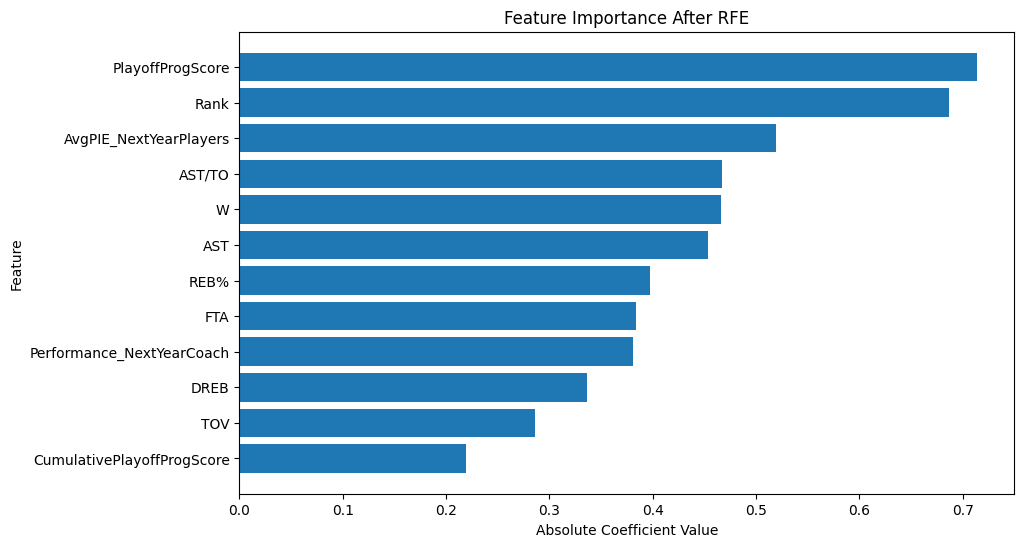

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(



Evaluation metrics for the final model:
Accuracy - Mean: 0.8295, Std: 0.0808
Precision - Mean: 0.8385, Std: 0.1222
Recall - Mean: 0.8446, Std: 0.0774
F1 - Mean: 0.8350, Std: 0.0718
Roc_auc - Mean: 0.8827, Std: 0.0873
Specificity - Mean: 0.8143, Std: 0.1571

Final cross-validated accuracy (with best params): 0.8295


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:31: Futu

In [8]:
import pandas as pd
import numpy as np
import optuna
from sklearn.svm import LinearSVC
from sklearn.feature_selection import RFE
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, make_scorer
import matplotlib.pyplot as plt

# Load the dataset
dataset = pd.read_csv('../../cleaned_data/dataset.csv')

# Prepare features and label data
label = 'PlayoffNextSeason'
features = [col for col in dataset.columns if col != label]

X = dataset[features]
y = dataset[label]

# Handle missing values
X = X.fillna(X.mean())

# Scale the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

def specificity_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    return tn / (tn + fp)

# Define the objective function for Optuna with RFE
def objective(trial):
    # Suggest hyperparameters for SVM
    C = trial.suggest_float('C', 0.0001, 1000, log=True)
    max_iter = trial.suggest_int('max_iter', 100, 10000)

    n_features_to_select = trial.suggest_int('n_features_to_select', 1, len(features))

    # Create the SVM model (LinearSVC)
    base_model = LinearSVC(C=C, dual=True, max_iter=max_iter, random_state=42)

    # Perform RFE for feature selection
    rfe = RFE(estimator=base_model, n_features_to_select=n_features_to_select)
    X_selected = rfe.fit_transform(X, y)

    # Perform stratified k-fold cross-validation on selected features
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    cv_scores = cross_val_score(base_model, X_selected, y, cv=skf, scoring='accuracy', error_score='raise')

    # Return the mean accuracy as the objective value
    return np.mean(cv_scores)

# Create an Optuna study and optimize
study = optuna.create_study(direction='maximize', study_name="SVM with RFE Optimization")
study.optimize(objective, n_trials=100)

# Display the best parameters
print("\nBest parameters:")
print(study.best_params)
print(f"Best cross-validated accuracy from Optuna: {study.best_value:.4f}")

# Retrieve best parameters
best_params = study.best_params
best_model = LinearSVC(
    C=best_params['C'],
    max_iter=best_params['max_iter'],
    random_state=42
)

# Perform RFE with the best number of features
rfe = RFE(estimator=best_model, n_features_to_select=best_params['n_features_to_select'])
X_selected = rfe.fit_transform(X, y)
selected_features = [features[i] for i in range(len(features)) if rfe.support_[i]]
print(f"Selected Features: {selected_features}")

# Train the final model on selected features
best_model.fit(X_selected, y)

# Get feature importance (coefficients)
coefficients = best_model.coef_[0]
feature_importance = pd.DataFrame({
    'Feature': selected_features,
    'Coefficient': coefficients,
    'Absolute Importance': np.abs(coefficients)
}).sort_values(by='Absolute Importance', ascending=False)

print("\nFeature Importance After RFE:")
print(feature_importance)

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Absolute Importance'])
plt.xlabel('Absolute Coefficient Value')
plt.ylabel('Feature')
plt.title('Feature Importance After RFE')
plt.gca().invert_yaxis()
plt.show()

# Evaluate the final model on multiple metrics with fixed random state for CV
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc',
    'specificity': make_scorer(specificity_score)
}

final_skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_results = cross_validate(best_model, X_selected, y, cv=final_skf, scoring=scoring)

# Print results
print("\nEvaluation metrics for the final model:")
for metric in scoring.keys():
    scores = cv_results[f'test_{metric}']
    print(f"{metric.capitalize()} - Mean: {np.mean(scores):.4f}, Std: {np.std(scores):.4f}")

# For direct comparison, print the final accuracy again using the same CV as in the objective
final_cv_scores = cross_val_score(best_model, X_selected, y, cv=final_skf, scoring='accuracy')
print(f"\nFinal cross-validated accuracy (with best params): {np.mean(final_cv_scores):.4f}")
